In [1]:
import os
os.chdir("/home/ec2-user/SageMaker/foodi-ml/")

In [2]:
from importlib import reload
import numpy as np

In [3]:
from addict import Dict

In [4]:
import os
import torch
from tqdm import tqdm

import params
from retrieval.train import train
from retrieval.utils import helper
from retrieval.model import loss
from retrieval.model.model import Retrieval
from retrieval.data.loaders import get_loaders
from retrieval.utils.logger import create_logger
from retrieval.utils.helper import load_model
from retrieval.utils.file_utils import load_yaml_opts, parse_loader_name

# Run

In [5]:
def get_data_path(opt):
    if 'DATA_PATH' not in os.environ:
        if not opt.dataset.data_path:
            raise Exception('''
                DATA_PATH not specified.
                Please, run "$ export DATA_PATH=/path/to/dataset"
                or add path to yaml file
            ''')
        return opt.dataset.data_path
    else:
        return os.environ['DATA_PATH']

## 1. Loaders

In [6]:
from retrieval.data.loaders import get_loaders, get_loader

In [7]:
os.environ["DATA_PATH"] = "/home/ec2-user/SageMaker/data/"

options = "options/adapt/foodi-ml/i2t.yaml"

args = {
    "options": options,
}
args = Dict(args)
opt = load_yaml_opts(args.options)

# Get path of the data
data_path = get_data_path(opt)

In [8]:
loader_name=opt.dataset.loader_name
data_path=data_path
data_info=opt.dataset.train.data
data_split='train'
vocab_paths=opt.dataset.vocab_paths
ngpu=torch.cuda.device_count()
text_repr=opt.dataset.text_repr
workers=4
local_rank=0

In [9]:
print(loader_name)
print(data_path)
print(data_info)
print(data_split)
print(vocab_paths)
print(ngpu)
print(text_repr)
print(workers)
print(local_rank)

image
/home/ec2-user/SageMaker/data/
foodiml.es
train
['.vocab_cache/foodiml_vocab.json']
1
word
4
0


In [10]:
batch_size = opt.dataset["train"]["batch_size"]

In [11]:
opt.dataset["train"]

{'batch_size': 128, 'workers': 1, 'data': 'foodiml.es'}

### 1.1 Inspecting get_loader

In [12]:
def parse_loader_name(data_name):
    if '.' in data_name:
        name, lang = data_name.split('.')
        return name, lang
    else:
        return data_name, None

In [13]:
data_info

'foodiml.es'

In [14]:
data_name, lang = parse_loader_name(data_info)

In [15]:
print((data_name, lang))

('foodiml', 'es')


In [16]:
from retrieval.data import datasets
from retrieval.data import adapters
datasets = reload(datasets)
adapters = reload(adapters)

In [17]:
__loaders__ = {
    'dummy': {
        'class': datasets.DummyDataset,
    },
    'precomp': {
        'class': datasets.PrecompDataset,
    },
    'tensor': {
        'class': datasets.PrecompDataset,
    },
    'lang': {
        'class': datasets.CrossLanguageLoader,
    },
    'image': {
        'class': datasets.ImageDataset,
    },
    'birds': {
        'class': datasets.Birds,
    },
}

In [18]:
def get_dataset_class(loader_name):
    loader = __loaders__[loader_name]
    return loader['class']

In [19]:
#loader_name = "image"
dataset_class = get_dataset_class("image")

#### 1.1.1 Loading vocabulary from using Tokenizer

In [20]:
vocab_paths

['.vocab_cache/foodiml_vocab.json']

In [21]:
from retrieval.data.tokenizer import Tokenizer

In [22]:
tokenizers = []
for vocab_path in vocab_paths:
    tokenizers.append(Tokenizer(vocab_path))

#### 1.1.2 Loading dataset class (ImageDataset class)

In [23]:
# TODO: inspect why here we needed tokenizers[0]

In [24]:
dataset = dataset_class(
        data_path=data_path,
        data_name=data_name,
        data_split=data_split,
        tokenizer=tokenizers[0],
        lang=lang,
    )

#### Image Dataset deep dive ----------------------------------------(1)

In [25]:
data_path=data_path
data_name=data_name
data_split=data_split
tokenizer=tokenizers[0]
lang=lang

In [26]:
from retrieval.data.datasets import ImageDataset

In [27]:
imagedataset = ImageDataset(
    data_path=data_path,
    data_name=data_name,
    data_split=data_split,
    tokenizer=tokenizers[0],
    lang=lang,
)

In [205]:
imagedataset._fetch_captions()

In [207]:
imagedataset.length

8011

##### FoodiML deep dive ------------------------------------(2)

In [104]:
from retrieval.data.adapters import FoodiML

In [105]:
print((data_path, data_split))

('/home/ec2-user/SageMaker/data/', 'train')


In [106]:
data_path

'/home/ec2-user/SageMaker/data/'

In [108]:
foodiml_wrapper = FoodiML(
    data_path = imagedataset.full_path,
    data_split = data_split
)

In [109]:
fd = foodiml_wrapper.data

In [110]:
fd.keys()

dict_keys(['images', 'dataset'])

In [111]:
len(fd["images"])

8011

In [112]:
fd["images"][0]

{'imgid': 0,
 'sentences': [{'tokens': ['coca-cola',
    'zero',
    'azúcar',
    'lata',
    '330ml',
    '.',
    'refrescos'],
   'raw': 'coca-cola zero azúcar lata 330ml. refrescos ',
   'imgid': 0}],
 'split': 'train',
 'filename': '0000000_0000000_1422139257.png'}

In [114]:
import numpy as np
np.array(foodiml_wrapper.image_ids)

array([   0,    1,    2, ..., 8008, 8009, 8010])

In [115]:
foodiml_wrapper.img_captions[0]

['coca-cola zero azúcar lata 330ml. refrescos ']

In [116]:
foodiml_wrapper.img_dict[0]

{'imgid': 0,
 'sentences': [{'tokens': ['coca-cola',
    'zero',
    'azúcar',
    'lata',
    '330ml',
    '.',
    'refrescos'],
   'raw': 'coca-cola zero azúcar lata 330ml. refrescos ',
   'imgid': 0}],
 'split': 'train',
 'filename': '0000000_0000000_1422139257.png'}

##### FINISH: FoodiML deep dive ------------------------------------(2)

In [117]:
# access to the data_wrapper (flickr) image_ids dictionary
imagedataset._fetch_captions()

In [118]:
len(imagedataset.captions)

8011

In [119]:
imagedataset.captions[0]

'coca-cola zero azúcar lata 330ml. refrescos '

In [120]:
imagedataset.length

8011

In [121]:
# CREATES THE TRANSFORMS for normalizing and scaling/resizing image
imagedataset.transform

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [123]:
imagedataset.captions_per_image

5

In [198]:
dataset._fetch_captions()

In [199]:
dataset.ids

range(0, 8011)

In [200]:
dataset.length = len(dataset.ids)

In [201]:
dataset.length

8011

#### FINISH: Image Dataset deep dive ----------------------------------------(1)

In [28]:
dataset

ImageDataset.foodiml.train.es

In [29]:
filename = dataset.data_wrapper.get_filename_by_image_id(766)
filename

PosixPath('images/0000766_0000996_1148236877.png')

In [30]:
img_path = dataset.data_path / filename

In [31]:
# Deafault loading of the original image
from torchvision.datasets.folder import default_loader
image = default_loader(img_path)

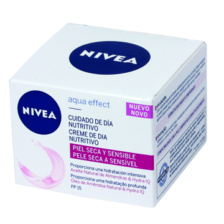

In [32]:
image

In [33]:
image.size

(224, 224)

In [34]:
image_transformed = dataset.transform(image)

In [35]:
image_transformed.shape

torch.Size([3, 224, 224])

In [36]:
# Applyied transformer of the loaded image index 0
dataset.load_img(0).shape

torch.Size([3, 224, 224])

In [44]:
dataset[0]['image'].shape

torch.Size([3, 224, 224])

In [45]:
cap_tokens

'caption'

In [46]:
index

'index'

In [47]:
image_id

'img_id'

In [48]:
dataset.captions[0]

'coca-cola zero azúcar lata 330ml. refrescos '

In [49]:
tokenizer.vocab.get_word(2)

'<start>'

In [50]:
tokenizer.vocab.get_word(4)

'coca-cola'

In [51]:
tokenizer.vocab.get_word(5)

'zero'

In [52]:
print(dataset)

foodiml.train.es


In [53]:
sampler = None
shuffle = (data_split == 'train')

#### 1.1.3 Collate

In [54]:
text_repr

'word'

In [55]:
from retrieval.data import collate_fns

In [98]:
class Collate:

    def __init__(self, text_repr='words'):
        if text_repr == 'liwe':
            self.padding = liwe_padding
        else:
            self.padding = default_padding
        pass

    def __call__(self, data):
        attributes = data[0].keys()

        batch = Dict()
        for att in attributes:
            batch[att] = _preprocessing_fn[att]([x[att] for x in data])

        return batch

In [101]:
collate = Collate(text_repr)

In [57]:
from torch.utils.data import DataLoader

In [58]:
shuffle = (data_split == 'train')
shuffle

True

In [59]:
# Change when implementing cuda and ngpu > 0
sampler = None

In [60]:
# Dataloader
loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=True,
        collate_fn=collate,
        num_workers=workers,
        sampler=sampler,
    )

In [61]:
#next(iter(loader))

In [102]:
input_collate_data = [dataset[i] for i in range(5)]

In [103]:
len(input_collate_data)

5

In [104]:
sample = input_collate_data[0]

In [105]:
sample["caption"]

tensor([ 2,  4,  5,  6,  7,  8,  9, 10,  3])

In [106]:
attributes = input_collate_data[0].keys()

In [107]:
attributes

dict_keys(['image', 'caption', 'index', 'img_id'])

In [88]:
# Padding
input_padding = [x['caption'] for x in input_collate_data]

In [89]:
input_padding[0]

tensor([ 2,  4,  5,  6,  7,  8,  9, 10,  3])

In [90]:
batch = Dict()
batch['caption'] = collate.padding([x['caption'] for x in input_collate_data])

In [94]:
batch_tensor, batch_lengths = batch['caption']

In [96]:
batch_tensor.shape

torch.Size([5, 11])

In [110]:
# Try collate
input_collate_data = [dataset[i] for i in range(5)]
collate = Collate()
batch = collate(input_collate_data)

In [115]:
batch['image'].shape

torch.Size([5, 3, 224, 224])

### 1.2 Inspecting get_loaders (gives error)

In [ ]:
data_path = data_path
local_rank = args.local_rank
opt = opt
opt["dataset"]["loader_name"] = "image"

opt.dataset.vocab_paths

train_loader = get_loader(
        data_split='train',
        data_path=data_path,
        data_info=opt.dataset.train.data,
        loader_name=opt.dataset.loader_name,
        local_rank=local_rank,
        text_repr=opt.dataset.text_repr,
        vocab_paths=opt.dataset.vocab_paths,
        ngpu=torch.cuda.device_count(),
        **opt.dataset.train
    )

## 1.3 Get tokenizers

The previous step we loaded all the loaders, in our case, the "loader" we returned in 1.1, is returned in the run.py as train_loader:

In [84]:
train_loader = loader 

In [85]:
def get_tokenizers(train_loader):
    tokenizers = train_loader.dataset.tokenizers
    if type(tokenizers) != list:
        tokenizers = [tokenizers]
    return tokenizers

In [86]:
train_loader.dataset.tokenizer

In [87]:
# Get tokenizer gets error because the attribute train_loader.dataset.tokenizers does not exist
# it only exists train_loader.dataset.tokenizer
tokenizers = [train_loader.dataset.tokenizer]

### 1.3.1 Deep dive tokenizer

In [88]:
tokenizer = train_loader.dataset.tokenizer

In [89]:
# How is this tokenizer created? 
# Inside get_loader (loaders.py) in the tokenizers.append(Tokenizer)

In [90]:
vocab_path

'.vocab_cache/f30k_precomp.json'

In [91]:
tkk = Tokenizer(vocab_path)

2021-08-09 16:35:04,118 - [INFO    ] - Loaded vocab containing 8347 tokens
2021-08-09 16:35:04,119 - [INFO    ] - Loaded from .vocab_cache/f30k_precomp.json.
2021-08-09 16:35:04,119 - [INFO    ] - Created tokenizer with init 8347 tokens.


#### Deep dive on Tokenizer --------------------- (1)

In [107]:
# created in retrieval > data > loaders.py line 60

In [92]:
from retrieval.data.tokenizer import Vocabulary

In [93]:
# Vocabulary class

In [94]:
vocab = Vocabulary()

In [95]:
vocab.add_word("hey")
vocab.add_word("how")

In [96]:
vocab.word2idx

{'hey': 0, 'how': 1}

In [97]:
vocab.idx2word

{0: 'hey', 1: 'how'}

In [98]:
vocab.idx

2

In [99]:
# Tokenizer class

In [100]:
vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<unk>')
vocab.add_word('<start>')
vocab.add_word('<end>')

char_level = True
if char_level:
    vocab.add_word(' ') # Space is allways #2


In [101]:
# Inspect Tokenizer.load

In [102]:
import json 

path = vocab_path
with open(path) as f:
    state = json.load(f)

In [103]:
len(state["word2idx"])

8347

In [104]:
# Overwrites previous definition of the vocabulary
vocab = Vocabulary()
vocab.word2idx = state['word2idx']
vocab.idx2word = {v: k for k, v in vocab.word2idx.items()}
vocab.idx = max(vocab.idx2word)

In [105]:
state['char_level']

False

In [106]:
state['max_len']

#### FINISH: Deep dive on Tokenizer --------------------- (1)

## 1.4 Retrieval

In [117]:
# see this issue
# https://github.com/pytorch/pytorch/issues/17543

In [119]:
model = Retrieval(**opt.model, tokenizers=tokenizers)

### 1.4.1 Deep dive Retrieval --------------------------------- (1)

# 1.5 Set Criterion

In [122]:
from retrieval.model import loss

In [130]:
def set_criterion(opt, model):
    if 'name' in opt.criterion:
        logger.info(opt.criterion)
        multimodal_criterion = loss.get_loss(**opt.criterion)
        multilanguage_criterion = loss.get_loss(**opt.criterion)
    else:
        multimodal_criterion = loss.ContrastiveLoss(**opt.criterion)
        multilanguage_criterion = loss.ContrastiveLoss(**opt.ml_criterion)
    set_model_criterion(opt, model, multilanguage_criterion, multimodal_criterion)
    # return multimodal_criterion, multilanguage_criterion


def set_model_criterion(opt, model, multilanguage_criterion, multimodal_criterion):
    model.mm_criterion = multimodal_criterion
    model.ml_criterion = None
    if len(opt.dataset.adapt.data) > 0:
        model.ml_criterion = multilanguage_criterion

In [131]:
multimodal_criterion = loss.ContrastiveLoss(**opt.criterion)
multilanguage_criterion = loss.ContrastiveLoss(**opt.ml_criterion)

In [138]:
model.ml_criterion

In [ ]:
set_criterion(opt, model)